<a href="https://colab.research.google.com/github/ummaruje/attention_nn_using_google_command/blob/main/epitome_speech_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
useColab=True
if useColab:
    %tensorflow_version 2.x
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechDownloader.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechGenerator.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/audioUtils.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechModels.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/requirements.txt
    !pip install -r requirements.txt
  

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for kapre: filename=kapre-0.2.0-py3-none-any.whl size=12321 sha256=56acffbd9e9a4b0722768eb27d789ba814e9ef801f21aa104b5a5ba6ce85160d
  Stored in directory: /root/.cache/pip/wheels/55/ea/b8/d830efb21ee5154a0f4392a8b156b5a6a553cf81593deb6145
Successfully built kapre
  Attempting uninstall: kapre
    Found existing installation: kapre 0.3.5
    Uninstalling kapre-0.3.5:
      Successfully uninstalled kapre-0.3.5


In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8932381975136102737
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14509932544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14925192500400604146
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
#%load_ext autoreload
#%autoreload 2

import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
import SpeechModels

In [ ]:
# Download and prepare all data
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=2, task='35word')

  5%|▌         | 5.66k/110k [00:00<00:01, 56.6kKB/s]

110kKB [00:02, 54.3kKB/s]                          
  0%|          | 5.21k/2.37M [00:00<00:45, 52.1kKB/s]

2.37MKB [00:46, 50.8kKB/s]                           


Extracting sd_GSCmdV2/test.tar.gz into sd_GSCmdV2/test/
Extracting sd_GSCmdV2/train.tar.gz into sd_GSCmdV2/train/


  0%|          | 0/4890 [00:00<?, ?it/s]

Converting test set WAVs to numpy files


100%|██████████| 4890/4890 [00:06<00:00, 723.13it/s] 


Converting training set WAVs to numpy files


100%|██████████| 105835/105835 [02:58<00:00, 592.05it/s]


Done preparing Google Speech commands dataset version 2


In [ ]:
#We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(nCategs)

dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
84849
36


In [ ]:
#Speech Data Generator, Use Keras to create a generator that reads files on the fly.
sr = 16000 #we know this one for google audios
iLen = 16000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
# handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

# use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

311

In [ ]:
audios, classes = valGen.__getitem__(5)
classes

array([28,  7, 20,  1,  9, 19, 12, 19,  7,  3,  2, 26,  3, 10,  4, 29, 28,
       10, 33,  4, 12, 19,  2, 25, 15,  1,  3, 10, 13, 25, 21,  3])

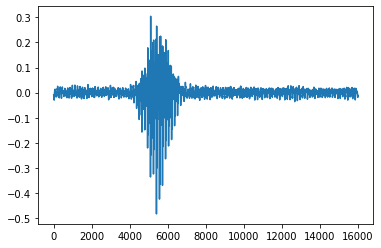

In [ ]:
# librosa.output.write_wav('file.wav', audios[4], sr, norm=False)
plt.plot(audios[4])

In [ ]:
from tensorflow.keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential()

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 125, 1)        1091664   
_________________________________________________________________
normalization2d_1 (Normaliza (None, 80, 125, 1)        0         
Total params: 1,091,664
Trainable params: 1,091,664
Non-trainable params: 0
_________________________________________________________________


In [ ]:
melspec = melspecModel.predict( audios.reshape((-1,1,iLen)) )
melspec.shape

(32, 80, 125, 1)

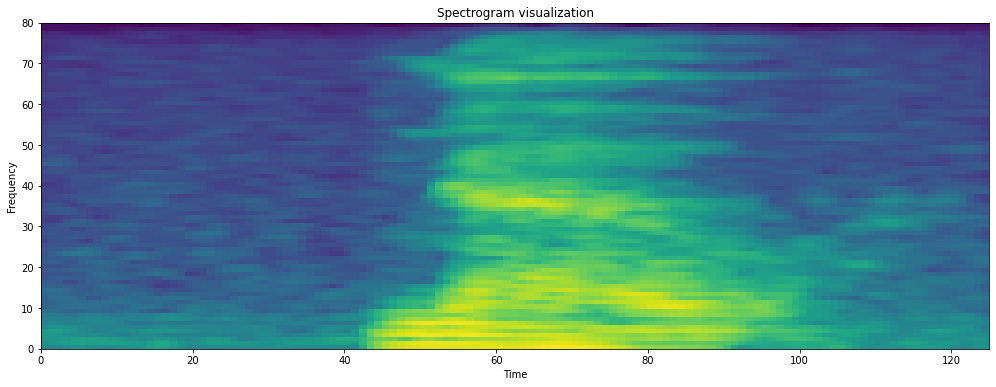

In [ ]:
plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[9,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [ ]:
# Check if mel spectrogram matches the one computed with librosa
librosa_melspec = librosa.feature.melspectrogram(y=audios[9], sr=sr, n_fft=1024,
                                                 hop_length=128, power=1.0, #window='hann',
                                                 n_mels=80, fmin=40.0, fmax=sr/2)
S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)

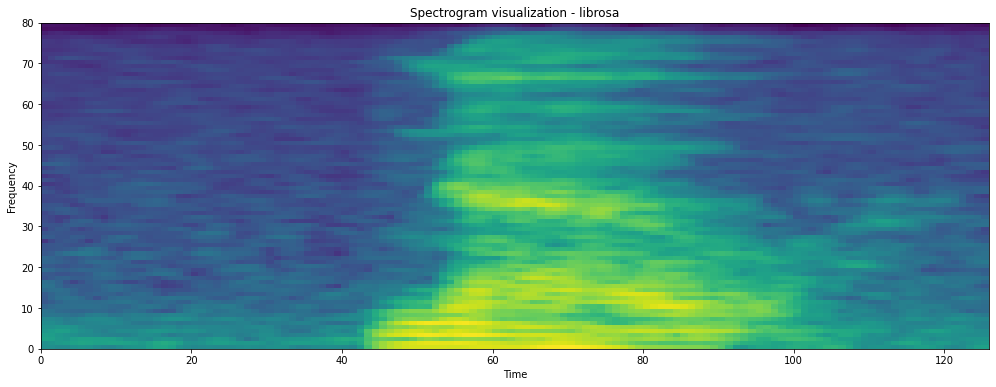

In [ ]:
plt.figure(figsize=(17,6))
plt.pcolormesh(S_dB)

plt.title('Spectrogram visualization - librosa')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [ ]:
#Models, Create Keras models to see if the generators are working properly
from tensorflow.keras.models import Model, load_model

from kapre.time_frequency import Melspectrogram, Spectrogram

In [ ]:
#self-attention LSTM
#nCategs=36
#sr=16000
#iLen=16000
#from keras import layers as L

model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, None, 1)  1091664     reshape_1[0][0]                  
__________________________________________________________________________________________________
mel_stft_norm (Normalization2D) (None, 80, None, 1)  0           mel_stft[0][0]                   
____________________________________________________________________________________________

In [ ]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-attRNN2.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, checkpointer, lrate])

model.save('model-attRNN2.h5')

Epoch 1/60
Changing learning rate to 0.001
2651/2651 - 99s - loss: 0.8652 - sparse_categorical_accuracy: 0.7557 - val_loss: 0.3883 - val_sparse_categorical_accuracy: 0.8948

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.89480, saving model to model-attRNN2.h5
Epoch 2/60
Changing learning rate to 0.001
2651/2651 - 93s - loss: 0.3437 - sparse_categorical_accuracy: 0.9030 - val_loss: 0.2923 - val_sparse_categorical_accuracy: 0.9192

Epoch 00002: val_sparse_categorical_accuracy improved from 0.89480 to 0.91921, saving model to model-attRNN2.h5
Epoch 3/60
Changing learning rate to 0.001
2651/2651 - 92s - loss: 0.2710 - sparse_categorical_accuracy: 0.9232 - val_loss: 0.2805 - val_sparse_categorical_accuracy: 0.9218

Epoch 00003: val_sparse_categorical_accuracy improved from 0.91921 to 0.92182, saving model to model-attRNN2.h5
Epoch 4/60
Changing learning rate to 0.001
2651/2651 - 91s - loss: 0.2236 - sparse_categorical_accuracy: 0.9365 - val_loss: 0.2525 - val_sparse_c

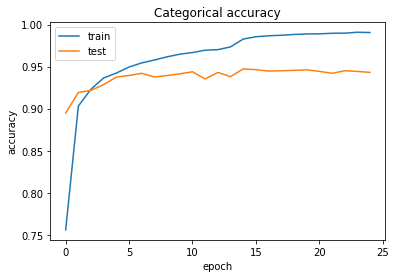

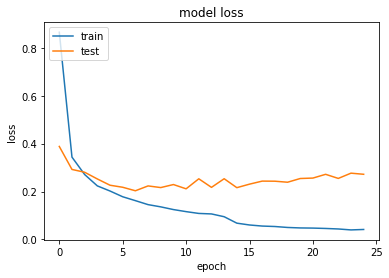

In [ ]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# load best model according to cross-validation - model-attRNN
# model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })
model.load_weights('model-attRNN.h5')

In [ ]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [ ]:
valEval = model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.0537097230553627, 0.9868445992469788] 
Validation: [0.2111138105392456, 0.950160801410675] 
Test: [0.2502748370170593, 0.9403907060623169]


In [ ]:
attSpeechModel = Model(inputs=model.input,
                                 outputs=[model.get_layer('output').output, 
                                          model.get_layer('attSoftmax').output,
                                          model.get_layer('mel_stft').output])

In [ ]:
audios, classes = valGen.__getitem__(3)
classes

array([ 1,  7, 11,  1, 15,  4, 22,  2, 15, 32, 11, 20,  1, 24, 24,  4,  1,
       14, 10, 10, 11,  6, 10,  5, 14, 22,  7,  5, 16, 15, 14, 17])

In [ ]:
#8 - on, 13 - one, 7 - right
idAudio = 8
classes[idAudio]

15

In [ ]:
outs, attW, specs = attSpeechModel.predict(audios)

In [ ]:
np.argmax(outs,axis=1)

array([ 1,  7, 11,  1, 15,  4, 22,  2, 33, 32, 11, 20,  1, 24, 24,  4,  1,
       14, 10, 10, 11,  6, 10,  3, 14, 22,  7,  5, 16, 15, 14, 17])

In [ ]:
specs.shape

(32, 80, 125, 1)

In [ ]:
y_pred = model.predict(x_test, verbose=1)

344/344 [==============================] - 7s 15ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [ ]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

Confusion matrix, without normalization


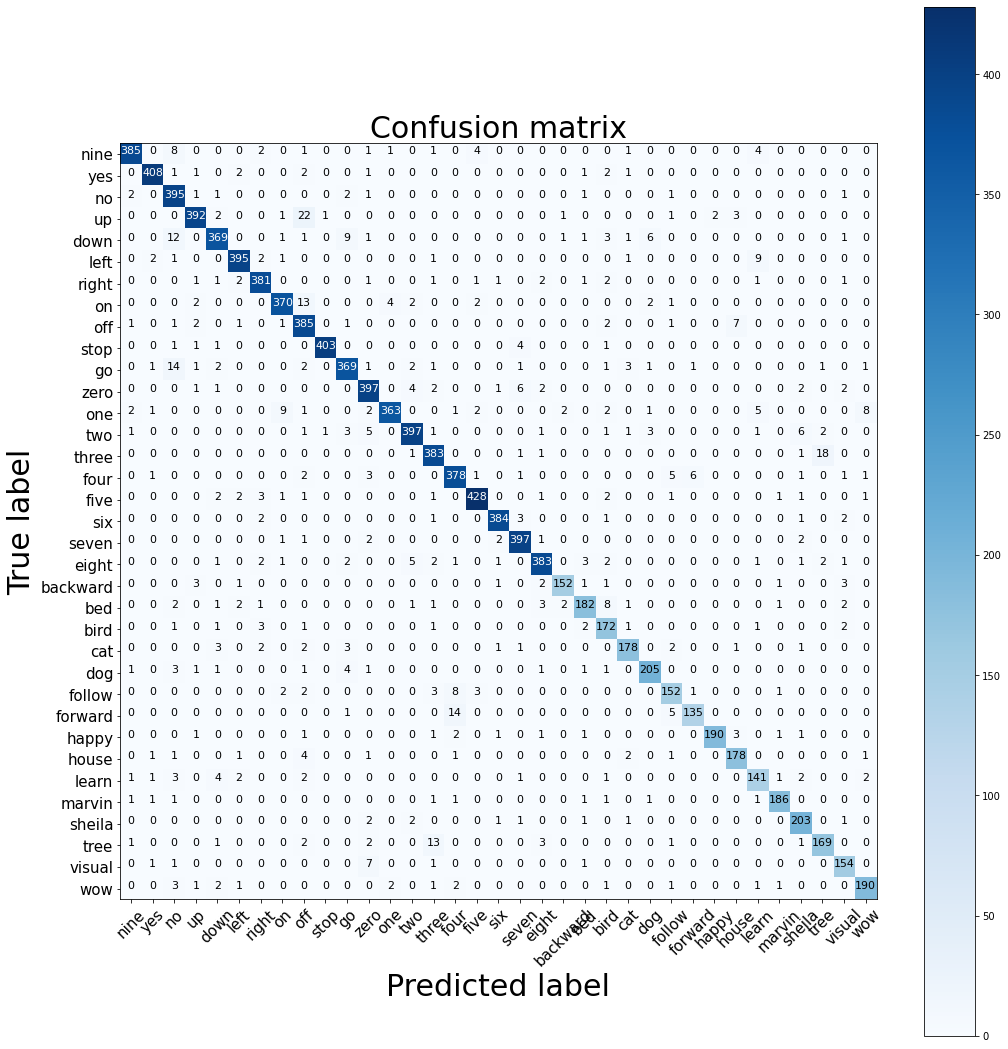

In [ ]:
audioUtils.plot_confusion_matrix(cm, classes, normalize=False)
